# **Diagnosing Diabetic Retinopathy**
### **Ben Chrepta and Fariha Tamboli**

#Part 0: Imports

In [ ]:
# imports
import random
import pathlib
from __future__ import print_function

import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid
from IPython.display import HTML, display

from tqdm.notebook import tqdm, trange
from time import sleep

import torch.nn.utils.prune as prune
from torch.optim.lr_scheduler import StepLR
import time
import matplotlib.animation as animation
import copy
from tqdm import tqdm
###
import os
import pandas as pd

import torch.utils.data as D
from torch.optim.lr_scheduler import ExponentialLR

from torchvision import models, transforms as T

from tqdm import tqdm_notebook

from glob import glob
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
sns.set(style = "darkgrid")
from fastai import *
from fastai.vision import *

import skimage.io
from skimage.io import imread
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2
from sklearn.utils import class_weight, shuffle
from keras.losses import binary_crossentropy
from keras.applications.resnet50 import preprocess_input
import keras.backend as K
import tensorflow as tf
from sklearn.metrics import f1_score, fbeta_score
from keras.utils import Sequence
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.autograd import Variable


# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion() 

# Part 1: Load the Dataset from Kaggle
For some reason, you have to run this twice to get it to work

Reference: https://towardsdatascience.com/setting-up-kaggle-in-google-colab-ebb281b61463 

In [ ]:
#source: https://towardsdatascience.com/setting-up-kaggle-in-google-colab-ebb281b61463
!pip install --upgrade kaggle
!mkdir .kaggle

import json
token = {'username':'ftamboli','key':'f332d8730eb66bc382fdd2c2167c658b'}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets list

!kaggle datasets list -s dr

!kaggle datasets download -d tanlikesmath/diabetic-retinopathy-resized -p /content

In [ ]:
!unzip \*.zip

#Part 2: Formatting/Visualizing the Images

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Index(['Unnamed: 0', 'Unnamed: 0.1', 'image', 'level'], dtype='object')
(14891,) (14891,) (3723,) (3723,)


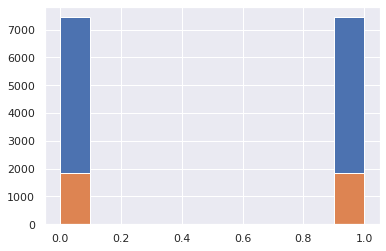

In [ ]:
#0 is no DR, 1 is DR (of any level)
from google.colab import drive
drive.mount('/content/drive')


# df_train = pd.read_csv('/content/trainLabels_cropped.csv')
df_train = pd.read_csv('/content/drive/MyDrive/trainlabels_cropped_equal.csv')
#https://drive.google.com/file/d/1lR2bZ4CtF0gO2pR0496TrGZY5_lfZkTX/view?usp=sharing 
df_train['level'] = df_train['level'].apply(lambda x: 1 if x!= 0 else 0)

print(df_train.columns)

x = df_train['image']
y = df_train['level']

x, y = shuffle(x, y, random_state=75)

train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.2,
                                                      stratify=y, random_state=75)
print(train_x.shape, train_y.shape, valid_x.shape, valid_y.shape)
train_y.hist()
valid_y.hist()

##Crop images

Here, we introduce three different ideas for cropping our images. We will choose the bright crop, since there is more contrast in the images.


Reference: These ideas are originally from @xhlulu on Kaggle. 

https://www.kaggle.com/xhlulu/aptos-2019-densenet-keras-starter



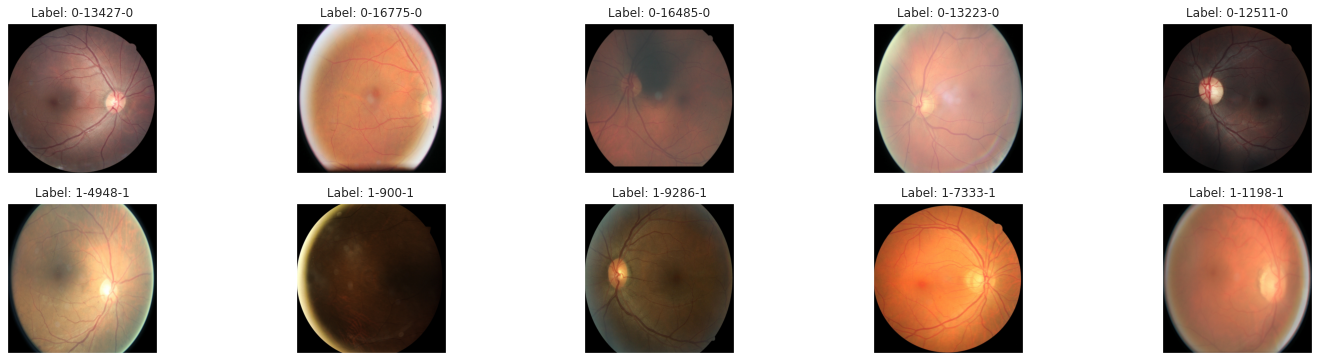

In [ ]:
#@title Simple Crop
#@markdown Crop out all the black border
fig = plt.figure(figsize=(25, 16))
# display 10 images from each class
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['level'] == class_id].sample(5, random_state=75).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"/content/resized_train_cropped/resized_train_cropped/{row['image']}.jpeg"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (512,512))

        plt.imshow(image)
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['level']) )

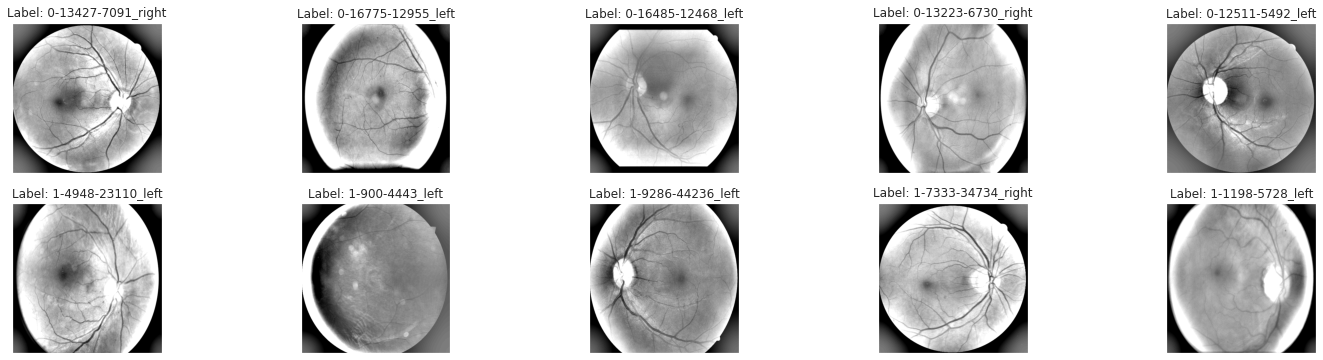

In [ ]:
#@title Black and White crop
#@markdown Build on the Simple Crop, then greyscale
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['level'] == class_id].sample(5, random_state=75).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"/content/resized_train_cropped/resized_train_cropped/{row['image']}.jpeg"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (512,512))
        image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , 512/10) ,-4 ,128) # the trick is to add this line

        plt.imshow(image, cmap='gray')
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['image']) )

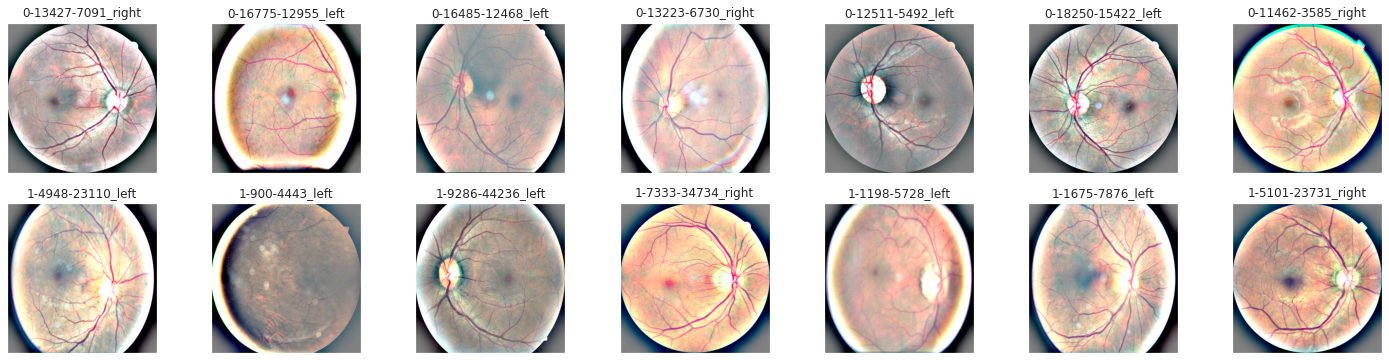

In [ ]:
#@title Bright Crop
#@markdown Change the illumination. Build on the Simple Crop
def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        h,w,_=img.shape
#         print(h,w)
        img1=cv2.resize(crop_image1(img[:,:,0]),(w,h))
        img2=cv2.resize(crop_image1(img[:,:,1]),(w,h))
        img3=cv2.resize(crop_image1(img[:,:,2]),(w,h))
        
#         print(img1.shape,img2.shape,img3.shape)
        img[:,:,0]=img1
        img[:,:,1]=img2
        img[:,:,2]=img3
        return img

def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image(image)
    image = cv2.resize(image, (512,512))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
    # print(type(image))
    return image

NUM_SAMP=7
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['level'] == class_id].sample(NUM_SAMP, random_state=75).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path=f"/content/resized_train_cropped/resized_train_cropped/{row['image']}.jpeg"
        image = load_ben_color(path,sigmaX=30)

        plt.imshow(image)
        ax.set_title('%d-%d-%s' % (class_id, idx, row['image']) )


#create new file with all the images


##Create the Bright Crop images, make a GDrive folder, **do not need to run this** (its already done)

In [ ]:
#@title Choose Bright Crop, Create new file of bright crop images
#@markdown This does not need to be run. This takes more than 2 hours. This is the link of the file of converted images: https://drive.google.com/drive/folders/1AutCwMZ7T0VXl7CrOAmgJ7ATdcoLSw2s?usp=sharing 
#Run time: 2.25 hours

# import shutil
# shutil.rmtree('/content/bright_images')

!mkdir bright_images

root_dir = '/content/'
content_dir = 'resized_train_cropped/resized_train_cropped/'
for f in df_train['image']:
   file_name = content_dir + f + '.jpeg'
   img_name = os.path.join(root_dir, file_name)
   image = load_ben_color(img_name,sigmaX=30)
   
   cv2.imwrite("/content/bright_images/"+ f + ".jpeg", image)

In [ ]:
#@title Take the generated images from above and put them into the google drive folder.
#@markdown This does not need to be run, since this is already done. 
from google.colab import drive
drive.mount('/content/drive')

root_dir = '/content/'
content_dir = 'bright_images/'
for f in df_train['image']:
  file_name = content_dir+f+'.jpeg'
  img_name = os.path.join(root_dir, file_name)
  print(img_name)
  image = io.imread(img_name)
  cv2.imwrite('/content/drive/My Drive/drive_bright_images/' + f + '.jpeg' , image)

Streaming output truncated to the last 5000 lines.
/content/bright_images/38126_left.jpeg
/content/bright_images/38126_right.jpeg
/content/bright_images/38127_left.jpeg
/content/bright_images/38127_right.jpeg
/content/bright_images/38130_left.jpeg
/content/bright_images/38130_right.jpeg
/content/bright_images/38132_left.jpeg
/content/bright_images/38132_right.jpeg
/content/bright_images/38134_left.jpeg
/content/bright_images/38134_right.jpeg
/content/bright_images/38136_left.jpeg
/content/bright_images/38136_right.jpeg
/content/bright_images/38137_left.jpeg
/content/bright_images/38137_right.jpeg
/content/bright_images/38149_left.jpeg
/content/bright_images/38149_right.jpeg
/content/bright_images/38150_left.jpeg
/content/bright_images/38150_right.jpeg
/content/bright_images/38153_left.jpeg
/content/bright_images/38153_right.jpeg
/content/bright_images/38154_left.jpeg
/content/bright_images/38154_right.jpeg
/content/bright_images/38155_left.jpeg
/content/bright_images/38155_right.jpeg
/

#Part 3: Loading Images
Create a dataset class, and pass it into a dataloader. 

Reference: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html 

In [ ]:
#@title Dataset Class

class DRDataset(Dataset):
  def __init__(self, csv_file, root_dir, transform=None):
    
    self.csv_data = pd.read_csv(csv_file)
    # self.csv_data = df_train
    self.root_dir = root_dir
    self.transform = transform
    # self.totensor = transform.ToTensor()

  def __len__(self):
    return(len(self.csv_data))

  def __getitem__ (self, idx): #df_train: image, level (0,1)

    # print(self.csv_data.iloc[idx, 2])
    file_name = self.csv_data.iloc[idx, 2] + ".jpeg"
    img_name = os.path.join(self.root_dir,
                                file_name)#self.csv_data.iloc[idx, 2])
    # image = io.imread(img_name)
    # image = torch.from_numpy(load_ben_color(img_name,sigmaX=30))
    image = torch.from_numpy(io.imread(img_name))
    # print("type of image is")
    # print(type(image))
    label = df_train['level'][idx] #self.csv_data.iloc[idx, 0]
    label = np.array([label])
    # print("type of label: ", type(label))
    label = label.astype('float')#.reshape(-1, 2)
    # print("label in loop: ", label)
    sample = {'image': image, 'label': label}
    if label == 0:
      label = np.array([1,0])
    elif label == 1:
      label = np.array([0,1])
    else: pass
    # if self.transform:
    #         sample = self.transform(sample)

    return image, label

def show_landmarks(image, label):
    """Show image with landmarks"""
    plt.imshow(image)
    # plt.scatter(label[:, 0], label[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

# plt.figure()
# show_landmarks(io.imread(os.path.join('data/faces/', img_name)),
#                landmarks)
# plt.show()

In [ ]:
#@title Dataloaders
dr_data = DRDataset(csv_file='/content/drive/My Drive/trainlabels_cropped_equal.csv',
                            root_dir='/content/drive/My Drive/drive_bright_images')
print(len(dr_data))
len_dr = len(dr_data)
train_size = (int)(0.8*len_dr)
test_size = len_dr - train_size
train_dr, test_dr = torch.utils.data.random_split(dr_data, [train_size, test_size])



batch_size = 100
train_loader = torch.utils.data.DataLoader(dataset=train_dr, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dr, batch_size=batch_size, shuffle=False)

# train_loader = torch.utils.data.DataLoader(dataset=train_dr, batch_size=batch_size, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_dr, batch_size=10, shuffle=True)

fig = plt.figure()

print(dr_data)
for i in range(len(dr_data)):
    image, label = dr_data[i]

    print(image.shape, label.shape, "label: ", label)

    ax = plt.subplot(1, 6, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    sample = {'image':image, 'label': label}
    show_landmarks(**sample)

    if i == 5:
        plt.show()
        break
        

#Part 4: Non-Deep Learning Benchmark: Logistic Regression Model

In [ ]:
#Reference: https://towardsdatascience.com/logistic-regression-on-mnist-with-pytorch-b048327f8d19 
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
        self.drop = torch.nn.Dropout(p=0.3)
        
    def forward(self, x):
        # print("before: ", x.shape)
        outputs = self.linear(x)
        outputs = self.drop(outputs)
        # outputs =  torch.argmax(outputs, dim =1)
        # print("after: ", outputs.shape)
        return outputs

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr_model = LogisticRegression(512*512*3, 2)
lr_model = lr_model.to(device)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(lr_model.parameters(), lr=0.01)
epochs = 10

In [ ]:
#@title Train Function
iter = 0
total_loss = []
total_acc = []
for epoch in range(int(epochs)):
    print("epoch num: ", epoch)
    epoch_loss = 0
    epoch_acc = 0
    correct = 0
    for i, (images, labels) in enumerate(train_loader):
        # print(images.view(images.shape[0], -1).shape)
        images = Variable(images.view(images.shape[0], -1)) #, requires_grad = True)
        labels = Variable(labels.squeeze().type(torch.DoubleTensor)) #, requires_grad = True)

        optimizer.zero_grad()
        outputs = lr_model(images.float()) #torch.argmax(lr_model(images.float()), dim = 1)
        # print("output: ", type(outputs), "labels: ", type(labels))
        loss = criterion(outputs.type(torch.DoubleTensor), labels)
        loss = Variable(loss, requires_grad = True)
        epoch_loss+=loss.item()
        _,predicted = torch.max(outputs.data, 1)
        new_labels = predicted.clone()
        int_it = 0
        for l in labels:
          p = l.data.cpu().numpy()[0]
          # print("p is: ", p)
          if p == 1:
            new_labels[int_it] = 0.
          elif p == 0:
            new_labels[int_it] = 1.
          else: pass
          int_it+=1

        
        correct = (predicted == new_labels).sum()
        epoch_acc += correct.data.cpu().data.tolist()

        loss.backward()
        optimizer.step()
        iter+=1
    total_loss.append(epoch_loss/len(train_loader))
    total_acc.append(epoch_acc/len(train_loader))

    


In [ ]:
test_predicted = predicted
test_new_labels = new_labels

In [ ]:
print(epoch_loss)
print(total_loss)
print(epoch_acc)
print(total_acc)

lr_model.eval()
lr_model.to(device)
epochs = 10
plt.plot(np.linspace(1, epochs, epochs).astype(int), total_loss)


lr_model.eval()
lr_model.to(device)
epochs = 10
plt.plot(np.linspace(1, epochs, epochs).astype(int), total_acc)
plt.legend()


from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_predicted,test_new_labels)
print("Confusion Matrix : ", cm)
print("True Negatives: ", cm[0][0], ", False Negatives: ", cm[1][0], ", True Positives: ", cm[1][1], ", False Positives: ", cm[0][1])

In [ ]:
#@title Test Function

def test_model(model, criterion):
    lr_model.eval()

    # TODO: Implement your testing loop with the `test_loader` data

    # for i in range(epochs):
      
    epoch_loss = 0 #total loss, total acc of entire test data set
    epoch_acc = 0 #count of correct values

    for i, (images, labels) in enumerate(test_loader):
      images = Variable(images.view(images.shape[0], -1)).to(device) #, requires_grad = True)
      labels = Variable(labels.squeeze().type(torch.DoubleTensor)).to(device) #, requires_grad = True)
      images = torch.flatten(images, 1)
      outputs = lr_model(images.float()) #torch.argmax(lr_model(images.float()), dim = 1)
      # print("output: ", type(outputs), "labels: ", type(labels))
      loss = criterion(outputs.type(torch.DoubleTensor), labels)
      # loss = Variable(loss, requires_grad = True)
      epoch_loss+=loss.item()
      _,predicted = torch.max(outputs.data, 1)
      # print('predicted: ', predicted.shape)
      # print('labels: ', labels.shape)
      new_labels = predicted.clone()
      int_it = 0
      for l in labels:
        p = l.data.cpu().numpy()[0]
        # print("p is: ", p)
        if p == 1:
          new_labels[int_it] = 0.
        elif p == 0:
          new_labels[int_it] = 1.
        else: pass
        int_it+=1

      correct = (predicted == new_labels).sum()
      epoch_acc += correct.data.cpu().data.tolist()

    testing_loss.append(epoch_loss/len(train_loader))
    testing_accuracy.append(epoch_acc/len(train_loader))

    return  testing_loss, testing_accuracy

In [ ]:
# criterion = nn.BCEWithLogitsLoss()
testing_accuracy = []
testing_loss = []
# epochs = 10
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(lr_model.parameters(), lr=0.01)
lr_testing_loss, lr_testing_accuracy = test_model(lr_model, criterion)

print("Logistic Regression - the testing loss is ", str(lr_testing_loss))
print("Logistic Regression - the testing accuracy is ", str(lr_testing_accuracy))



Logistic Regression - the testing loss is  [7.369272250003811]
Logistic Regression - the testing accuracy is  [12.61744966442953]


In [ ]:
train_predicted = predicted
train_new_labels = new_labels

In [ ]:

test_cm = confusion_matrix(train_predicted,train_new_labels)
print("Confusion Matrix : ", test_cm)
print("True Negatives: ", test_cm[0][0], ", False Negatives: ", test_cm[1][0], ", True Positives: ", test_cm[1][1], ", False Positives: ", test_cm[0][1])

Confusion Matrix :  [[26 20]
 [20 25]]
True Negatives:  26 , False Negatives:  20 , True Positives:  25 , False Positives:  20


#Ablation Study: Logistic Regression
Remove the dropout layer.

In [ ]:
#Reference: https://towardsdatascience.com/logistic-regression-on-mnist-with-pytorch-b048327f8d19 
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
        # self.drop = torch.nn.Dropout(p=0.3)
        
    def forward(self, x):
        outputs = self.linear(x)
        return outputs

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr_model = LogisticRegression(512*512*3, 2)
lr_model = lr_model.to(device)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(lr_model.parameters(), lr=0.01)
epochs = 10

In [ ]:
#@title Train Function
iter = 0
total_loss = []
total_acc = []
for epoch in range(int(epochs)):
    print("epoch num: ", epoch)
    epoch_loss = 0
    epoch_acc = 0
    correct = 0
    for i, (images, labels) in enumerate(train_loader):
        # print(images.view(images.shape[0], -1).shape)
        images = Variable(images.view(images.shape[0], -1)) #, requires_grad = True)
        labels = Variable(labels.squeeze().type(torch.DoubleTensor)) #, requires_grad = True)

        optimizer.zero_grad()
        outputs = lr_model(images.float()) #torch.argmax(lr_model(images.float()), dim = 1)
        # print("output: ", type(outputs), "labels: ", type(labels))
        loss = criterion(outputs.type(torch.DoubleTensor), labels)
        loss = Variable(loss, requires_grad = True)
        epoch_loss+=loss.item()
        _,predicted = torch.max(outputs.data, 1)
        new_labels = predicted.clone()
        int_it = 0
        for l in labels:
          p = l.data.cpu().numpy()[0]
          # print("p is: ", p)
          if p == 1:
            new_labels[int_it] = 0.
          elif p == 0:
            new_labels[int_it] = 1.
          else: pass
          int_it+=1

        
        correct = (predicted == new_labels).sum()
        epoch_acc += correct.data.cpu().data.tolist()

        loss.backward()
        optimizer.step()
        iter+=1
    total_loss.append(epoch_loss/len(train_loader))
    total_acc.append(epoch_acc/len(train_loader))

    


In [ ]:
print(epoch_loss)
print(total_loss)
print(epoch_acc)
print(total_acc)

lr_model.eval()
lr_model.to(device)
epochs = 10
plt.plot(np.linspace(1, epochs, epochs).astype(int), total_loss)


lr_model.eval()
lr_model.to(device)
epochs = 10
plt.plot(np.linspace(1, epochs, epochs).astype(int), total_acc)
plt.legend()

In [ ]:
ablation_train_predicted = predicted
ablation_train_new_labels = new_labels

In [ ]:

ablation_train_cm = confusion_matrix(ablation_train_predicted,ablation_train_new_labels)
print("Confusion Matrix : ", ablation_train_cm)
print("True Negatives: ", ablation_train_cm[0][0], ", False Negatives: ", ablation_train_cm[1][0], ", True Positives: ", ablation_train_cm[1][1], ", False Positives: ", ablation_train_cm[0][1])

In [ ]:
#@title Test Function

def test_model(model, criterion):
    lr_model.eval()

    # TODO: Implement your testing loop with the `test_loader` data

    # for i in range(epochs):
      
    epoch_loss = 0 #total loss, total acc of entire test data set
    epoch_acc = 0 #count of correct values

    for i, (images, labels) in enumerate(test_loader):
      images = Variable(images.view(images.shape[0], -1)).to(device) #, requires_grad = True)
      labels = Variable(labels.squeeze().type(torch.DoubleTensor)).to(device) #, requires_grad = True)
      images = torch.flatten(images, 1)
      outputs = lr_model(images.float()) #torch.argmax(lr_model(images.float()), dim = 1)
      # print("output: ", type(outputs), "labels: ", type(labels))
      loss = criterion(outputs.type(torch.DoubleTensor), labels)
      # loss = Variable(loss, requires_grad = True)
      epoch_loss+=loss.item()
      _,predicted = torch.max(outputs.data, 1)
      # print('predicted: ', predicted.shape)
      # print('labels: ', labels.shape)
      new_labels = predicted.clone()
      int_it = 0
      for l in labels:
        p = l.data.cpu().numpy()[0]
        # print("p is: ", p)
        if p == 1:
          new_labels[int_it] = 0.
        elif p == 0:
          new_labels[int_it] = 1.
        else: pass
        int_it+=1

      correct = (predicted == new_labels).sum()
      epoch_acc += correct.data.cpu().data.tolist()

    testing_loss.append(epoch_loss/len(train_loader))
    testing_accuracy.append(epoch_acc/len(train_loader))

    return  testing_loss, testing_accuracy

In [ ]:
# criterion = nn.BCEWithLogitsLoss()
testing_accuracy = []
testing_loss = []
# epochs = 10
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(lr_model.parameters(), lr=0.01)
lr_testing_loss, lr_testing_accuracy = test_model(lr_model, criterion)

print("Logistic Regression - the testing loss is ", str(lr_testing_loss))
print("Logistic Regression - the testing accuracy is ", str(lr_testing_accuracy))

Logistic Regression - the testing loss is  [16.76062204566288]
Logistic Regression - the testing accuracy is  [12.140939597315436]


In [ ]:
ablation_test_predicted = predicted
ablation_test_new_labels = new_labels

In [ ]:

ablation_test_cm = confusion_matrix(test_predicted,test_new_labels)
print("Confusion Matrix : ", ablation_test_cm)
print("True Negatives: ", ablation_test_cm[0][0], ", False Negatives: ", ablation_test_cm[1][0], ", True Positives: ", ablation_test_cm[1][1], ", False Positives: ", ablation_test_cm[0][1])